In [3]:
%load_ext autoreload
%autoreload 2

In [6]:
import os
import sys
sys.dont_write_bytecode = True
import json
import time
from datetime import datetime
import single_node_profiles_cpp as snp
import profiler
import numpy as np
from optimizer import BruteForceOptimizer, GreedyOptimizer
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline


[__init__.py:90] backend module://ipykernel.pylab.backend_inline version unknown


In [12]:
profs = snp.load_single_node_profiles(models=["inception", "tf-resnet-feats"], single_node_profs_dir="../results_cpp_benchmarker/bare_metal_profs_no_contention/")

[single_node_profiles_cpp.py:256] Loading profs from bare_metal_profs_no_contention


In [17]:
old_profs = snp.load_single_node_profiles(models=["inception", "tf-resnet-feats"])

[single_node_profiles_cpp.py:256] Loading profs from single_model_profs_contention_tuned


In [13]:
profs.keys()

[u'inception', u'tf-resnet-feats']

In [7]:
dag = profiler.get_logical_pipeline("pipeline_one")
with open(os.path.abspath("../results_python_benchmarker/e2e_profs_new_metrics/incep_1-logreg_1-ksvm_1-resnet_1-180207_063416.json")) as f:
    sample_run = json.load(f)
print(dag.reference_node)
scale_factors = profiler.get_node_scale_factors(sample_run, dag.reference_node)
node_configs = profiler.get_node_configs_from_experiment(sample_run)
def which_stage(model_name):
    if model_name == "tf-kernel-svm" or model_name == "tf-log-reg":
        return "latency_stage"
    else:
        return "thru_stage"
node_profs = {name : profiler.NodeProfile(name, profs[name], which_stage(name)) for name, _ in node_configs.items()}

inception


In [19]:
old_resnet = profiler.NodeProfile("tf-resnet-feats", old_profs["tf-resnet-feats"], "thru_stage")
old_resnet_array = np.sort(resnet.profile[["mean_batch_size", "p99_latency", "thru_stage_mean_throughput_qps"]].values, axis=0)
old_resnet_array = resnet_array[np.argsort(resnet_array[:,0])]
old_resnet_array

array([[1.0000000e+00, 1.3254010e-01, 1.0000000e+01],
       [2.0000000e+00, 1.3424957e-01, 1.9700000e+01],
       [4.0000000e+00, 1.3839000e-01, 3.8600000e+01],
       [8.0000000e+00, 1.4921285e-01, 7.6100000e+01],
       [1.2000000e+01, 1.5238963e-01, 1.0520000e+02],
       [1.6000000e+01, 1.7264560e-01, 1.2620000e+02],
       [2.4000000e+01, 2.1201610e-01, 1.6890000e+02],
       [3.2000000e+01, 2.5663817e-01, 1.9150000e+02],
       [4.2870000e+01, 5.3025450e-01, 2.0900000e+02]])

In [20]:
resnet = profiler.NodeProfile("tf-resnet-feats", profs["tf-resnet-feats"], "thru_stage")
resnet_array = np.sort(resnet.profile[["mean_batch_size", "p99_latency", "thru_stage_mean_throughput_qps"]].values, axis=0)
resnet_array = resnet_array[np.argsort(resnet_array[:,0])]
resnet_array

array([[1.0000000e+00, 1.0887625e-01, 9.9000000e+00],
       [2.0000000e+00, 1.1104000e-01, 2.0400000e+01],
       [4.0000000e+00, 1.2155254e-01, 3.9900000e+01],
       [8.0000000e+00, 1.4182200e-01, 7.3600000e+01],
       [1.6000000e+01, 1.5272976e-01, 1.2670000e+02],
       [3.2000000e+01, 2.7838175e-01, 1.5160000e+02]])

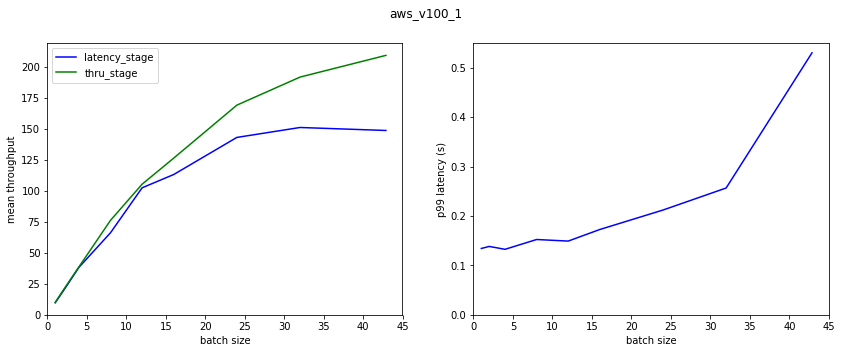

In [21]:
old_resnet.plot_profile()

[font_manager.py:1343] findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans (u'/data/ges/project-env/lib/python2.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000
[font_manager.py:1343] findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to DejaVu Sans (u'/data/ges/project-env/lib/python2.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


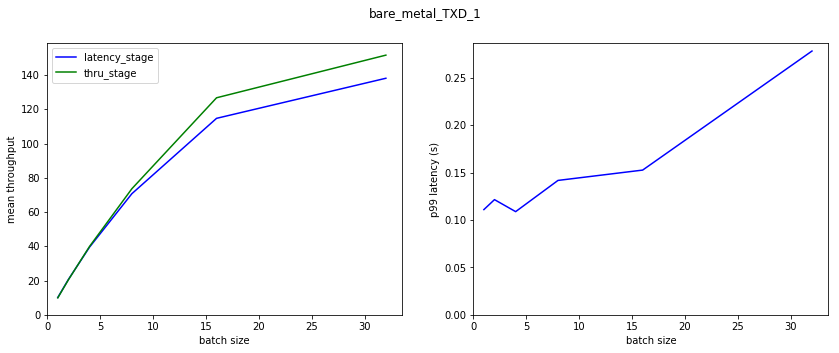

In [16]:
resnet.plot_profile()

In [23]:
old_profs["tf-resnet-feats"]

,contention,p99_latency,num_cpus_per_replica,thru_stage_std_throughput_qps,mean_queue_size,cost,cloud,thru_stage_mean_throughput_qps,gpu_type,mean_batch_size,latency_stage_std_throughput_qps,fname,latency_stage_mean_throughput_qps
0,1000,0.134250,1,0.056473,0.0,2.5945,aws,10.0,v100,1.00,0.042345,v100.model-tf-resnet-feats.contention-1000.bat...,9.7
1,1000,0.138390,1,0.113562,0.0,2.5945,aws,19.7,v100,2.00,0.116139,v100.model-tf-resnet-feats.contention-1000.bat...,19.0
2,1000,0.530254,1,2.987826,0.0,2.5945,aws,209.0,v100,42.87,14.698076,v100.model-tf-resnet-feats.contention-1000.bat...,148.5
3,1000,0.149213,1,2.469013,0.0,2.5945,aws,105.2,v100,12.00,2.008059,v100.model-tf-resnet-feats.contention-1000.bat...,102.3
4,1000,0.396805,1,3.248879,0.0,2.5945,aws,200.3,v100,64.00,3.258619,v100.model-tf-resnet-feats.contention-1000.bat...,173.9
5,1000,0.132540,1,0.413928,0.0,2.5945,aws,38.6,v100,4.00,0.347424,v100.model-tf-resnet-feats.contention-1000.bat...,38.2
6,1000,0.212016,1,5.547813,0.0,2.5945,aws,168.9,v100,24.00,2.705263,v100.model-tf-resnet-feats.contention-1000.bat...,142.9
7,1000,0.256638,1,3.177793,0.0,2.5945,aws,191.5,v100,32.00,3.360039,v100.model-tf-resnet-feats.contention-1000.bat...,150.9
8,1000,0.152390,1,0.603664,0.0,2.5945,aws,76.1,v100,8.00,1.136636,v100.model-tf-resnet-feats.contention-1000.bat...,66.1
9,1000,0.172646,1,2.097706,0.0,2.5945,aws,126.2,v100,16.00,3.036616,v100.model-tf-resnet-feats.contention-1000.bat...,113.0


In [11]:
inception = profiler.NodeProfile("inception", profs["inception"], "thru_stage")
inception

array([[1.0000000e+00, 3.4842640e-02, 3.2400000e+01],
       [2.0000000e+00, 3.8789750e-02, 6.1900000e+01],
       [4.0000000e+00, 5.7467350e-02, 1.0380000e+02],
       [8.0000000e+00, 7.4904870e-02, 1.3770000e+02],
       [1.6000000e+01, 1.2304392e-01, 1.7480000e+02],
       [3.2000000e+01, 2.1674803e-01, 2.0300000e+02]])

In [18]:
%config Application.log_level="INFO"
from optimizer import BruteForceOptimizer, GreedyOptimizer
opt = GreedyOptimizer(dag, scale_factors, node_profs)
cloud = "aws"
initial_config = {"tf-resnet-feats": profiler.NodeConfig(name="tf-resnet-feats",
                                                          num_cpus=1,
                                                          gpu_type="v100",
                                                          batch_size=1,
                                                          num_replicas=1,
                                                          cloud=cloud),
                  "inception": profiler.NodeConfig(name="inception",
                                                      num_cpus=1,
                                                      gpu_type="k80",
                                                      batch_size=1,
                                                      num_replicas=1,
                                                      cloud=cloud),
                  "tf-log-reg": profiler.NodeConfig(name="tf-log-reg",
                                                      num_cpus=1,
                                                      gpu_type="none",
                                                      batch_size=1,
                                                      num_replicas=1,
                                                      cloud=cloud),
                  "tf-kernel-svm": profiler.NodeConfig(name="tf-kernel-svm",
                                                      num_cpus=1,
                                                      gpu_type="none",
                                                      batch_size=1,
                                                      num_replicas=1,
                                                      cloud=cloud),
                 }
# 24 ms mean inter-arrival time
with open("../experiments/cached_arrival_processes/398.deltas", 'r') as f:
    deltas = np.array([float(l.strip()) for l in f]).flatten()
arrival_cached = np.cumsum(deltas)
opt.select_optimal_config(cloud, 0.35, 21, initial_config, arrival_cached)

INFO:optimizer:

Evaluating step batch_size
INFO:optimizer:
Old config: NodeConfig(tf-resnet-feats, 1, v100, 1, 1, aws)
New config: NodeConfig(tf-resnet-feats, 1, v100, 2.0, 1, aws)
INFO:optimizer:Doing network calc
INFO:optimizer:Response time: inf, T_s=0.11817702000000001, T_q=inf
INFO:optimizer:Node: tf-resnet-feats, Action: batch_size, bottleneck qpsd delta: 4.047022547697052
INFO:optimizer:Setting best action response time to inf
INFO:optimizer:

Evaluating step replication_factor
INFO:optimizer:
Old config: NodeConfig(tf-resnet-feats, 1, v100, 1, 1, aws)
New config: NodeConfig(tf-resnet-feats, 1, v100, 1, 2, aws)
INFO:optimizer:Doing network calc
INFO:optimizer:Response time: inf, T_s=0.11687844000000001, T_q=inf
INFO:optimizer:Node: tf-resnet-feats, Action: replication_factor, bottleneck qpsd delta: 0.0
INFO:optimizer:Upgrading bottleneck node tf-resnet-feats to NodeConfig(tf-resnet-feats, 1, v100, 2.0, 1, aws).
Increased QPSD by: 4.047022547697052.
New config: {'tf-resnet-feats

({'inception': NodeConfig(inception, 1, v100, 32.0, 3, aws),
  'tf-kernel-svm': NodeConfig(tf-kernel-svm, 1, none, 24.0, 1, aws),
  'tf-log-reg': NodeConfig(tf-log-reg, 1, none, 2.0, 1, aws),
  'tf-resnet-feats': NodeConfig(tf-resnet-feats, 1, v100, 24.0, 5, aws)},
 {'cost': 20.889,
  'latency': 0.16605398999999998,
  'throughput': 909.5999999999999},
 0.3403709438959971)

In [1]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logging.debug("test")

DEBUG:root:test


In [11]:
with open("arrival_deltas_ms", 'w') as f:
    for delta in np.diff(arrival_cached):
        f.write("{}\n".format(delta))

In [ ]:
import itertools
def brute_force_optimizer(dag, scale_factors, node_profs, cost_constraint, latency_constraint):
    """
        This doesn't loo
    """
    all_node_configs = [node_profs[node].enumerate_configs(max_replication_factor=3) for node in dag.nodes()]     
    all_pipeline_configs = itertools.product(*all_node_configs)
    num_valid_configs = 0
    best_config = None
    best_config_perf = None
    cur_index = 0
    for p_config in all_pipeline_configs:
        cur_index += 1
        if cur_index % 500 == 0:
            print("Processed {}".format(cur_index))
        cur_node_configs = {n.name: n for n in p_config}
        if not profiler.is_valid_pipeline_config(cur_node_configs):
            continue
        cur_config_perf = profiler.estimate_pipeline_performance_for_config(
            dag, scale_factors, cur_node_configs, node_profs)
        if cur_config_perf["latency"] <= latency_constraint and cur_config_perf["cost"] <= cost_constraint:
            if best_config is None:
                best_config = cur_node_configs
                best_config_perf = cur_config_perf
                print("Initializing config to {} ({})".format(best_config, best_config_perf))
            else:
                if cur_config_perf["throughput"] > best_config_perf["throughput"]:
                    best_config = cur_node_configs
                    best_config_perf = cur_config_perf
                    print("Updating config to {} ({})".format(best_config, best_config_perf))
        
    return best_config, best_config_perf

In [ ]:
start = datetime.now()
brute_force_optimizer(dag, scale_factors, node_profs, 7.0, 0.8)
end = datetime.now()
print("{}".format((end-start).total_seconds()))

In [ ]:
profiler.estimate_pipeline_performance_for_config(dag, scale_factors, node_configs, node_profs)

In [ ]:
groups = profs["alexnet"].groupby(["cloud","gpu_type","num_cpus_per_replica"])
groups

In [ ]:
for name, df in groups:
    print(name, df)